Cryptocurrency trading bot.

Hardcoded parameters.

In [1]:
traded_symbol = 'ETHBTC'
symbols = {'BTCUSDT': None, 'ETHBTC': None, 'ETHUSDT': None}
percentage_to_trade = 0.9999
interval = '1m'
window_1 = 2
window_2 = 2
period = '1 hour ago UTC'
min_periods = 14
api_key = 'yoyoyo'
api_secret = 'yeyeye'
kraken_key = 'yayaya'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends cryptowatch-sdk

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from time import sleep
from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import subprocess
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.graph_objects as go
import pylab as pl
import cryptowatch as cw

pd.options.mode.chained_assignment = None # This avoids SettingWithCopyWarnings

Function definitions.

In [4]:
def calculate_renko(dataset, brick_size=1):
    renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
    renko_.index.name = 'date'
    renko_ = Renko(renko_.reset_index())
    renko_.brick_size = brick_size
    renko_ = renko_.get_ohlc_data().set_index('date')
    renko_.index.name = 'time'
    return renko_.uptrend

def calculate_heikin_ashi(df):
    df = df.tz_localize(tz=None, ambiguous='infer')
    df = df[['open', 'high', 'low', 'close']].copy().astype('float')
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

    return heikin_ashi_df

def RSI(ticker, span=14):
    up = ticker['close'].astype(float).pct_change()
    down = up.copy()
    up[up < 0.0] = 0.0
    down[down > 0.0] = 0.0

    up = up.ewm(span=span).mean().fillna(method='pad')
    down = down.ewm(span=span).mean().abs().fillna(method='pad')

    ticker = up / down
    ticker = 100 - (100 / (1 + ticker))

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = ticker.iloc[1]
    return ticker.fillna(method='pad')

def calculate_MACD(ticker, span1=12, span2=26, average='exponential'):
    if average == 'linear':
        shorter = ticker['close'].rolling(window=span1).mean()
        longer = ticker['close'].rolling(window=span2).mean()
    if average == 'exponential':
        shorter = ticker['close'].ewm(span=span1).mean()
        longer = ticker['close'].ewm(span=span2).mean()

    ticker = shorter - longer

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = 0.0
    return ticker.fillna(method='pad')

def ATR(ticker, min_periods=14):
    ticker = ticker.astype(float)
    up = pd.DataFrame([ticker['high'].shift(), 
                       ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

    down = pd.DataFrame([ticker['low'].shift(), 
                         ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

    ticker = (up - down).ewm(alpha=1 / min_periods, 
                             min_periods=min_periods, 
                             adjust=False).mean()

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    return ticker.fillna(method='backfill')

def calculate_bollinger_bands(dataframe, period=20):
    df = dataframe.copy()
    df['MA'] = df['close'].rolling(period).mean()
    df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
    df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
    df['BB_width'] = df['BB_up'] - df['BB_down']
    df.dropna(inplace=True)
    return df['BB_width']

def average_directional_movement_index(df, n, n_ADX):
    dataset_index = df.index.copy()
    df = df.reset_index().drop(columns=['time']).astype(float)
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(), name='ADX')
    df = df.join(ADX)
    df.index = dataset_index
    return df

def commodity_channel_index(dataset, min_periods=20):
    PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
    CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                    PP.rolling(min_periods, min_periods=min_periods).std(),
                    name='CCI')
    dataset = dataset.join(CCI)
    return dataset['CCI']

def calculate_KDJ(dataset):
    def get_rsv(dataset):
        low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
        high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
        return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

    def calc_kd(column):
        k = 50.0
        for i in (1.0 / 3.0) * column:
            k = (2.0 / 3.0) * k + i
            yield k

    dataset['K'] = list(calc_kd(get_rsv(dataset)))
    dataset['D'] = list(calc_kd(dataset['K']))
    dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
    return dataset[['K', 'D', 'J']]

def get_symbol_on_Binance(symbol, quote_precision=8):
    last_price = [ticker['price'] for ticker in client.get_all_tickers() if ticker['symbol'] == symbol][0]
    last_price = "{:0.0{}f}".format(float(last_price), quote_precision)
    return last_price

def get_BTCUSD_price():
    api_call = 'curl https://api.cryptowat.ch/markets/bitstamp/btcusd/price?apikey=' + kraken_key
    json_response_serialized = subprocess.check_output(api_call, shell=True)
    json_response = json.loads(json_response_serialized)
    price = json_response['result']['price']
    return price

def get_kraken_OHLC():
    kraken_OHLC = cw.markets.get('BITSTAMP:BTCUSD', ohlc=True, periods=[interval])
    kraken_OHLC = pd.DataFrame(kraken_OHLC.__dict__['of_' + interval], columns=kraken_OHLC._legend)
    kraken_OHLC = kraken_OHLC.set_index('close timestamp')
    kraken_OHLC.index.name = 'time'
    kraken_OHLC = kraken_OHLC.applymap(lambda x: format(x, 'f'))
    kraken_OHLC.index = list(map(lambda timestamp: datetime.datetime.fromtimestamp(int(timestamp)), 
                                 kraken_OHLC.index))
    return kraken_OHLC

def download_dataset(symbol=traded_symbol, interval=interval):
    dataset_downloaded = \
        client.get_historical_klines(symbol=symbol, 
                                     interval=interval, 
                                     start_str=period)

    dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                      columns=['time', 
                                               'open', 
                                               'high', 
                                               'low', 
                                               'close', 
                                               'volume', 
                                               'Close time', 
                                               'Quote asset volume', 
                                               'Number of trades', 
                                               'Taker buy base asset volume', 
                                               'Taker buy quote asset volume', 
                                               'Ignore'])

    four_hours = 14400
    milliseconds = 1000

    dataset_downloaded['time'] = \
        dataset_downloaded['time'].apply(lambda timestamp: \
                                         datetime.datetime.fromtimestamp((timestamp / \
                                                                          milliseconds) - \
                                                                         four_hours))

    dataset_downloaded = dataset_downloaded[['time', 
                                             'open', 
                                             'high', 
                                             'low', 
                                             'close', 
                                             'volume', 
                                             'Number of trades']]

    dataset_downloaded.set_index('time', inplace=True)

    return dataset_downloaded

def compute_balances_BTCUSDT(pair=traded_symbol, first=8, second=8):
    buy_USDT_balance = float(client.get_asset_balance(asset=second)['free'])
    buy_BTC_last_price = float(client.get_ticker(symbol=symbol)['lastPrice'])
    buy_BTC_balance = buy_USDT_balance / buy_BTC_last_price
    sell_BTC_balance = float(client.get_asset_balance(asset=first)['free'])
    sell_USDT_last_price = float(client.get_ticker(symbol=symbol)['lastPrice'])
    sell_USDT_balance = sell_BTC_balance * sell_USDT_last_price
    USDT_balance_combined = sell_USDT_balance + buy_USDT_balance
    BTC_balance_combined = buy_BTC_balance + sell_BTC_balance

    return buy_USDT_balance, buy_BTC_last_price, buy_BTC_balance, sell_BTC_balance, sell_USDT_last_price, sell_USDT_balance, USDT_balance_combined, BTC_balance_combined

def print_balances_BTCUSDT(buy_USDT_balance, 
                           buy_BTC_last_price, 
                           buy_BTC_balance, 
                           sell_BTC_balance, 
                           sell_USDT_last_price, 
                           sell_USDT_balance, 
                           USDT_balance_combined, 
                           BTC_balance_combined):

    print('buy_USDT_balance: ', buy_USDT_balance)
    print('buy_BTC_last_price: ', buy_BTC_last_price)
    print('buy_BTC_balance: ', buy_BTC_balance)
    print('sell_BTC_balance: ', sell_BTC_balance)
    print('sell_USDT_last_price: ', sell_USDT_last_price)
    print('sell_USDT_balance: ', sell_USDT_balance)
    print('USDT_balance_combined: ', USDT_balance_combined)
    print('BTC_balance_combined: ', BTC_balance_combined)

class Cryptocurrency:
    def __init__(self, client, symbol, interval=interval):
        symbol_info = client.get_symbol_info(symbol)
        self.symbol = symbol
        self.interval = interval
        self.base_asset = symbol_info['baseAsset']
        self.quote_asset = symbol_info['quoteAsset']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'PRICE_FILTER'][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'LOT_SIZE'][0]
        self.base_asset_precision = client.get_symbol_info(symbol)['baseAssetPrecision']
        self.quote_asset_precision = client.get_symbol_info(symbol)['quotePrecision']
        self.dataset = download_dataset(symbol=symbol, interval=interval)
        self.calculate_indicators()
        self.calculate_balance()
        self.calculate_position()

    def calculate_position(self):
        if self.buy_BTC_balance > self.sell_BTC_balance:
            self.position = 'sell'
            self.state = 'entry'
        elif self.sell_BTC_balance > self.buy_BTC_balance:
            self.position = 'buy'
            self.state = 'entry'

    def calculate_balance(self):
        self.buy_USDT_balance, self.buy_BTC_last_price, self.buy_BTC_balance, self.sell_BTC_balance, self.sell_USDT_last_price, self.sell_USDT_balance, self.USDT_balance_combined, self.BTC_balance_combined = compute_balances_BTCUSDT(pair=self.symbol, first=self.base_asset, second=self.quote_asset)
        self.BTC_balance_combined_before = self.BTC_balance_combined
        self.USDT_balance_combined_before = self.USDT_balance_combined

    def calculate_indicators(self):
        self.heikin_ashi = calculate_heikin_ashi(self.dataset.rolling(window=window_1).mean().fillna(method='backfill', axis='index')).ewm(span=window_2).mean().fillna(method='backfill', axis='index')
        self.trend = ((self.heikin_ashi['close'] - self.heikin_ashi['open']) > 0).astype(int)
        self.CCI = commodity_channel_index(self.heikin_ashi, min_periods=20)
        self.brick_size = ATR(self.dataset, min_periods=min_periods).median()
        self.renko = calculate_renko(self.dataset, brick_size=self.brick_size)
        self.ADX = average_directional_movement_index(self.dataset, n=14, n_ADX=14).ADX.dropna()
        self.KDJ = calculate_KDJ(self.dataset.astype(float))
        self.MACD = calculate_MACD(self.dataset.astype(float))
        self.MACD_signal_line = self.MACD.ewm(span=9).mean()
        self.MACD_histogram = self.MACD - self.MACD_signal_line
        self.bollinger_bands = calculate_bollinger_bands(self.dataset.astype(float), period=20)

In [5]:
cw.api_key = kraken_key
client = Client(api_key, api_secret)

In [6]:
for symbol in symbols.keys():
    symbols[symbol] = Cryptocurrency(client, symbol, interval)
    print(symbols[symbol].dataset)

                              open           high            low  \
time                                                               
2020-04-24 12:43:00  7531.12000000  7531.57000000  7530.00000000   
2020-04-24 12:44:00  7530.26000000  7530.27000000  7529.62000000   
2020-04-24 12:45:00  7529.94000000  7534.53000000  7529.33000000   
2020-04-24 12:46:00  7533.11000000  7535.62000000  7532.67000000   
2020-04-24 12:47:00  7535.47000000  7535.63000000  7532.27000000   
2020-04-24 12:48:00  7532.70000000  7534.00000000  7529.98000000   
2020-04-24 12:49:00  7529.99000000  7530.00000000  7528.00000000   
2020-04-24 12:50:00  7529.93000000  7529.99000000  7528.25000000   
2020-04-24 12:51:00  7529.40000000  7529.58000000  7519.25000000   
2020-04-24 12:52:00  7522.98000000  7523.00000000  7520.00000000   
2020-04-24 12:53:00  7519.22000000  7522.09000000  7515.72000000   
2020-04-24 12:54:00  7521.13000000  7527.00000000  7520.95000000   
2020-04-24 12:55:00  7523.84000000  7526.0000000

In [7]:
for symbol in symbols.keys():
    print(symbol)
    print(symbols[symbol].heikin_ashi)
    fig = go.Figure(data=[go.Candlestick(x=symbols[symbol].heikin_ashi.index.to_series(), 
                                         open=symbols[symbol].heikin_ashi['open'], 
                                         high=symbols[symbol].heikin_ashi['high'], 
                                         low=symbols[symbol].heikin_ashi['low'], 
                                         close=symbols[symbol].heikin_ashi['close'])])

    fig.show()

BTCUSDT
                            open         high          low        close
2020-04-24 12:43:00  7530.690000  7530.920000  7529.810000  7530.382500
2020-04-24 12:44:00  7530.574687  7530.920000  7529.810000  7530.382500
2020-04-24 12:45:00  7530.494856  7531.944615  7529.578077  7530.715673
2020-04-24 12:46:00  7530.607383  7534.057625  7530.309430  7532.231438
2020-04-24 12:47:00  7531.413382  7535.106860  7531.314885  7533.488151
2020-04-24 12:48:00  7532.445929  7534.912019  7531.188121  7533.051284
2020-04-24 12:49:00  7532.746723  7533.568001  7529.722037  7531.401340
2020-04-24 12:50:00  7532.073610  7532.347286  7528.657183  7530.046074
2020-04-24 12:51:00  7531.059804  7531.151020  7525.385562  7528.196931
2020-04-24 12:52:00  7529.628403  7529.658808  7521.545122  7524.994756
2020-04-24 12:53:00  7527.311618  7527.321752  7519.088360  7521.996568
2020-04-24 12:54:00  7524.654116  7525.470581  7518.586119  7521.574689
2020-04-24 12:55:00  7523.114412  7526.156861  7520.2253

ETHBTC
                         open      high       low     close
2020-04-24 12:44:00  0.025007  0.025018  0.025001  0.025007
2020-04-24 12:45:00  0.025007  0.025018  0.025001  0.025007
2020-04-24 12:46:00  0.025007  0.025012  0.024996  0.025002
2020-04-24 12:47:00  0.025005  0.025006  0.024990  0.024996
2020-04-24 12:48:00  0.025001  0.025001  0.024988  0.024994
2020-04-24 12:49:00  0.024997  0.025003  0.024990  0.024996
2020-04-24 12:50:00  0.024997  0.025006  0.024992  0.024998
2020-04-24 12:51:00  0.024997  0.025006  0.024994  0.025000
2020-04-24 12:52:00  0.024999  0.025007  0.024996  0.025002
2020-04-24 12:53:00  0.025000  0.025011  0.025000  0.025006
2020-04-24 12:54:00  0.025003  0.025012  0.025003  0.025008
2020-04-24 12:55:00  0.025006  0.025009  0.025000  0.025005
2020-04-24 12:56:00  0.025005  0.025006  0.024994  0.024999
2020-04-24 12:57:00  0.025002  0.025003  0.024988  0.024994
2020-04-24 12:58:00  0.024998  0.024998  0.024983  0.024988
2020-04-24 12:59:00  0.024993  0.

ETHUSDT
                           open        high         low       close
2020-04-24 12:44:00  188.340000  188.430000  188.255000  188.325000
2020-04-24 12:45:00  188.334375  188.430000  188.255000  188.325000
2020-04-24 12:46:00  188.330481  188.409231  188.251538  188.310288
2020-04-24 12:47:00  188.320875  188.376000  188.267375  188.308406
2020-04-24 12:48:00  188.314850  188.355248  188.249050  188.292738
2020-04-24 12:49:00  188.303893  188.328379  188.216305  188.268379
2020-04-24 12:50:00  188.286186  188.319456  188.205430  188.264458
2020-04-24 12:51:00  188.275341  188.296482  188.148468  188.224813
2020-04-24 12:52:00  188.250086  188.257133  188.082819  188.156601
2020-04-24 12:53:00  188.203348  188.205697  188.054273  188.109700
2020-04-24 12:54:00  188.156526  188.171899  188.051424  188.101566
2020-04-24 12:55:00  188.129047  188.167300  188.043808  188.101355
2020-04-24 12:56:00  188.115202  188.127952  188.004603  188.070452
2020-04-24 12:57:00  188.092827  188.097

2020-04-24 12:43:00    0
2020-04-24 12:44:00    0
2020-04-24 12:45:00    1
2020-04-24 12:46:00    1
2020-04-24 12:47:00    1
2020-04-24 12:48:00    1
2020-04-24 12:49:00    0
2020-04-24 12:50:00    0
2020-04-24 12:51:00    0
2020-04-24 12:52:00    0
2020-04-24 12:53:00    0
2020-04-24 12:54:00    0
2020-04-24 12:55:00    0
2020-04-24 12:56:00    1
2020-04-24 12:57:00    1
2020-04-24 12:58:00    1
2020-04-24 12:59:00    1
2020-04-24 13:00:00    1
2020-04-24 13:01:00    1
2020-04-24 13:02:00    1
2020-04-24 13:03:00    1
2020-04-24 13:04:00    1
2020-04-24 13:05:00    1
2020-04-24 13:06:00    1
2020-04-24 13:07:00    0
2020-04-24 13:08:00    1
2020-04-24 13:09:00    1
2020-04-24 13:10:00    1
2020-04-24 13:11:00    1
2020-04-24 13:12:00    1
2020-04-24 13:13:00    1
2020-04-24 13:14:00    1
2020-04-24 13:15:00    1
2020-04-24 13:16:00    1
2020-04-24 13:17:00    0
2020-04-24 13:18:00    0
2020-04-24 13:19:00    0
2020-04-24 13:20:00    1
2020-04-24 13:21:00    1
2020-04-24 13:22:00    1


/home/samuel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



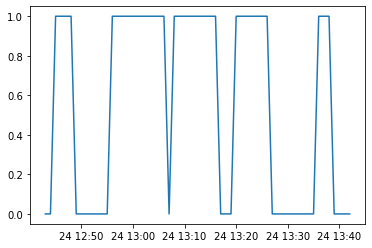

2020-04-24 12:44:00    0
2020-04-24 12:45:00    0
2020-04-24 12:46:00    0
2020-04-24 12:47:00    0
2020-04-24 12:48:00    0
2020-04-24 12:49:00    0
2020-04-24 12:50:00    1
2020-04-24 12:51:00    1
2020-04-24 12:52:00    1
2020-04-24 12:53:00    1
2020-04-24 12:54:00    1
2020-04-24 12:55:00    0
2020-04-24 12:56:00    0
2020-04-24 12:57:00    0
2020-04-24 12:58:00    0
2020-04-24 12:59:00    0
2020-04-24 13:00:00    0
2020-04-24 13:01:00    1
2020-04-24 13:02:00    1
2020-04-24 13:03:00    1
2020-04-24 13:04:00    1
2020-04-24 13:05:00    1
2020-04-24 13:06:00    1
2020-04-24 13:07:00    1
2020-04-24 13:08:00    1
2020-04-24 13:09:00    1
2020-04-24 13:10:00    0
2020-04-24 13:11:00    0
2020-04-24 13:12:00    0
2020-04-24 13:13:00    0
2020-04-24 13:14:00    0
2020-04-24 13:15:00    1
2020-04-24 13:16:00    1
2020-04-24 13:17:00    1
2020-04-24 13:18:00    1
2020-04-24 13:19:00    1
2020-04-24 13:20:00    1
2020-04-24 13:21:00    1
2020-04-24 13:22:00    1
2020-04-24 13:23:00    0


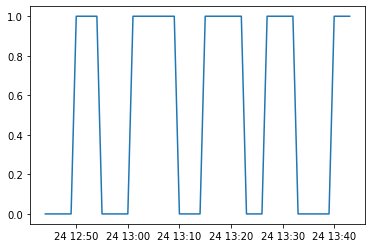

2020-04-24 12:44:00    0
2020-04-24 12:45:00    0
2020-04-24 12:46:00    0
2020-04-24 12:47:00    0
2020-04-24 12:48:00    0
2020-04-24 12:49:00    0
2020-04-24 12:50:00    0
2020-04-24 12:51:00    0
2020-04-24 12:52:00    0
2020-04-24 12:53:00    0
2020-04-24 12:54:00    0
2020-04-24 12:55:00    0
2020-04-24 12:56:00    0
2020-04-24 12:57:00    0
2020-04-24 12:58:00    0
2020-04-24 12:59:00    0
2020-04-24 13:00:00    0
2020-04-24 13:01:00    1
2020-04-24 13:02:00    1
2020-04-24 13:03:00    1
2020-04-24 13:04:00    1
2020-04-24 13:05:00    1
2020-04-24 13:06:00    1
2020-04-24 13:07:00    1
2020-04-24 13:08:00    1
2020-04-24 13:09:00    1
2020-04-24 13:10:00    1
2020-04-24 13:11:00    1
2020-04-24 13:12:00    0
2020-04-24 13:13:00    0
2020-04-24 13:14:00    1
2020-04-24 13:15:00    1
2020-04-24 13:16:00    1
2020-04-24 13:17:00    1
2020-04-24 13:18:00    1
2020-04-24 13:19:00    1
2020-04-24 13:20:00    1
2020-04-24 13:21:00    1
2020-04-24 13:22:00    1
2020-04-24 13:23:00    1


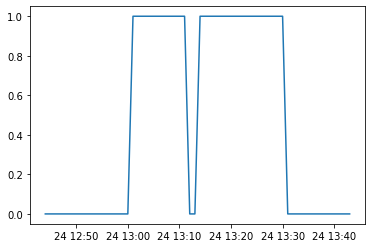

In [8]:
for symbol in symbols.keys():
    print(symbols[symbol].trend)
    plt.plot(symbols[symbol].trend)
    plt.show()

2020-04-24 12:43:00         NaN
2020-04-24 12:44:00         NaN
2020-04-24 12:45:00         NaN
2020-04-24 12:46:00         NaN
2020-04-24 12:47:00         NaN
2020-04-24 12:48:00         NaN
2020-04-24 12:49:00         NaN
2020-04-24 12:50:00         NaN
2020-04-24 12:51:00         NaN
2020-04-24 12:52:00         NaN
2020-04-24 12:53:00         NaN
2020-04-24 12:54:00         NaN
2020-04-24 12:55:00         NaN
2020-04-24 12:56:00         NaN
2020-04-24 12:57:00         NaN
2020-04-24 12:58:00         NaN
2020-04-24 12:59:00         NaN
2020-04-24 13:00:00         NaN
2020-04-24 13:01:00         NaN
2020-04-24 13:02:00    0.676271
2020-04-24 13:03:00    1.192710
2020-04-24 13:04:00    1.508590
2020-04-24 13:05:00    1.572751
2020-04-24 13:06:00    1.466435
2020-04-24 13:07:00    1.347846
2020-04-24 13:08:00    1.310110
2020-04-24 13:09:00    1.324704
2020-04-24 13:10:00    1.298862
2020-04-24 13:11:00    1.280020
2020-04-24 13:12:00    1.243445
2020-04-24 13:13:00    1.187060
2020-04-

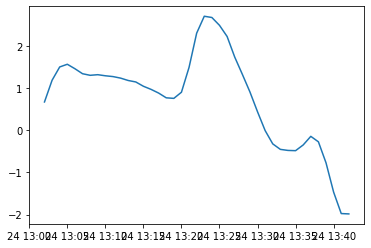

2020-04-24 12:44:00         NaN
2020-04-24 12:45:00         NaN
2020-04-24 12:46:00         NaN
2020-04-24 12:47:00         NaN
2020-04-24 12:48:00         NaN
2020-04-24 12:49:00         NaN
2020-04-24 12:50:00         NaN
2020-04-24 12:51:00         NaN
2020-04-24 12:52:00         NaN
2020-04-24 12:53:00         NaN
2020-04-24 12:54:00         NaN
2020-04-24 12:55:00         NaN
2020-04-24 12:56:00         NaN
2020-04-24 12:57:00         NaN
2020-04-24 12:58:00         NaN
2020-04-24 12:59:00         NaN
2020-04-24 13:00:00         NaN
2020-04-24 13:01:00         NaN
2020-04-24 13:02:00         NaN
2020-04-24 13:03:00    0.521027
2020-04-24 13:04:00    1.747106
2020-04-24 13:05:00    2.120641
2020-04-24 13:06:00    1.913890
2020-04-24 13:07:00    1.718014
2020-04-24 13:08:00    1.591626
2020-04-24 13:09:00    1.348362
2020-04-24 13:10:00    1.116564
2020-04-24 13:11:00    0.931164
2020-04-24 13:12:00    0.694579
2020-04-24 13:13:00    0.474575
2020-04-24 13:14:00    0.447553
2020-04-

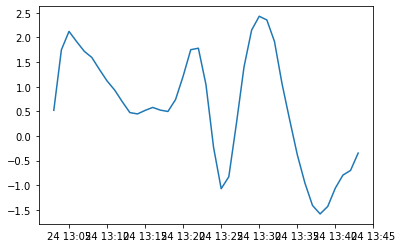

2020-04-24 12:44:00         NaN
2020-04-24 12:45:00         NaN
2020-04-24 12:46:00         NaN
2020-04-24 12:47:00         NaN
2020-04-24 12:48:00         NaN
2020-04-24 12:49:00         NaN
2020-04-24 12:50:00         NaN
2020-04-24 12:51:00         NaN
2020-04-24 12:52:00         NaN
2020-04-24 12:53:00         NaN
2020-04-24 12:54:00         NaN
2020-04-24 12:55:00         NaN
2020-04-24 12:56:00         NaN
2020-04-24 12:57:00         NaN
2020-04-24 12:58:00         NaN
2020-04-24 12:59:00         NaN
2020-04-24 13:00:00         NaN
2020-04-24 13:01:00         NaN
2020-04-24 13:02:00         NaN
2020-04-24 13:03:00    1.134399
2020-04-24 13:04:00    1.949518
2020-04-24 13:05:00    2.139710
2020-04-24 13:06:00    1.962411
2020-04-24 13:07:00    1.773923
2020-04-24 13:08:00    1.620178
2020-04-24 13:09:00    1.483376
2020-04-24 13:10:00    1.351966
2020-04-24 13:11:00    1.203666
2020-04-24 13:12:00    1.041122
2020-04-24 13:13:00    0.938832
2020-04-24 13:14:00    0.926571
2020-04-

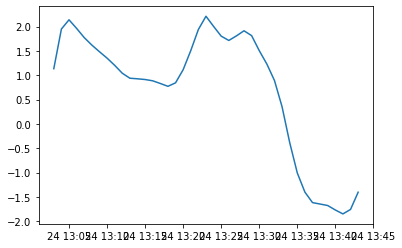

In [9]:
for symbol in symbols.keys():
    print(symbols[symbol].CCI)
    plt.plot(symbols[symbol].CCI)
    plt.show()

time
2020-04-24 12:43:00     True
2020-04-24 12:45:00     True
2020-04-24 12:46:00     True
2020-04-24 12:51:00    False
2020-04-24 12:51:00    False
2020-04-24 12:52:00    False
2020-04-24 13:00:00     True
2020-04-24 13:01:00     True
2020-04-24 13:03:00     True
2020-04-24 13:20:00     True
2020-04-24 13:21:00     True
2020-04-24 13:23:00     True
2020-04-24 13:31:00    False
2020-04-24 13:40:00    False
Name: uptrend, dtype: bool


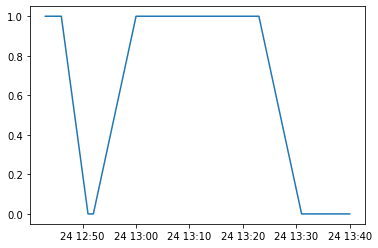

time
2020-04-24 12:44:00     True
2020-04-24 13:03:00     True
2020-04-24 13:27:00     True
2020-04-24 13:37:00    False
Name: uptrend, dtype: bool


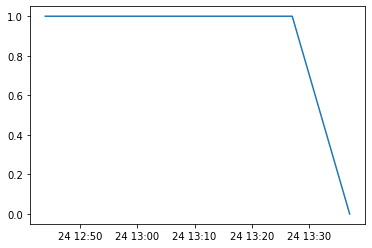

time
2020-04-24 12:44:00     True
2020-04-24 12:56:00    False
2020-04-24 13:01:00     True
2020-04-24 13:02:00     True
2020-04-24 13:03:00     True
2020-04-24 13:03:00     True
2020-04-24 13:22:00     True
2020-04-24 13:27:00     True
2020-04-24 13:34:00    False
2020-04-24 13:40:00    False
Name: uptrend, dtype: bool


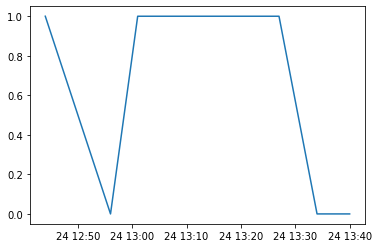

In [10]:
for symbol in symbols.keys():
    print(symbols[symbol].renko)
    plt.plot(symbols[symbol].renko)
    plt.show()

time
2020-04-24 13:09:00    0.433347
2020-04-24 13:10:00    0.461975
2020-04-24 13:11:00    0.485859
2020-04-24 13:12:00    0.511883
2020-04-24 13:13:00    0.534939
2020-04-24 13:14:00    0.554454
2020-04-24 13:15:00    0.583521
2020-04-24 13:16:00    0.567875
2020-04-24 13:17:00    0.562131
2020-04-24 13:18:00    0.557217
2020-04-24 13:19:00    0.570051
2020-04-24 13:20:00    0.599975
2020-04-24 13:21:00    0.628350
2020-04-24 13:22:00    0.659691
2020-04-24 13:23:00    0.686687
2020-04-24 13:24:00    0.713516
2020-04-24 13:25:00    0.675051
2020-04-24 13:26:00    0.641846
2020-04-24 13:27:00    0.599453
2020-04-24 13:28:00    0.524045
2020-04-24 13:29:00    0.470250
2020-04-24 13:30:00    0.437195
2020-04-24 13:31:00    0.404932
2020-04-24 13:32:00    0.366309
2020-04-24 13:33:00    0.332884
2020-04-24 13:34:00    0.303951
2020-04-24 13:35:00    0.299195
2020-04-24 13:36:00    0.297027
2020-04-24 13:37:00    0.265737
2020-04-24 13:38:00    0.245285
2020-04-24 13:39:00    0.277926
202

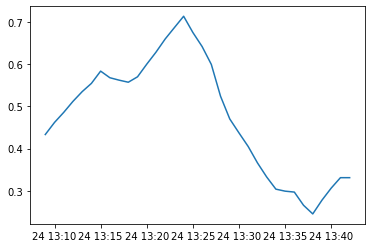

time
2020-04-24 13:10:00    0.402432
2020-04-24 13:11:00    0.345507
2020-04-24 13:12:00    0.298016
2020-04-24 13:13:00    0.269210
2020-04-24 13:14:00    0.250480
2020-04-24 13:15:00    0.240408
2020-04-24 13:16:00    0.210742
2020-04-24 13:17:00    0.210998
2020-04-24 13:18:00    0.228070
2020-04-24 13:19:00    0.272923
2020-04-24 13:20:00    0.311367
2020-04-24 13:21:00    0.315217
2020-04-24 13:22:00    0.273765
2020-04-24 13:23:00    0.266621
2020-04-24 13:24:00    0.246533
2020-04-24 13:25:00    0.224473
2020-04-24 13:26:00    0.232012
2020-04-24 13:27:00    0.245966
2020-04-24 13:28:00    0.278406
2020-04-24 13:29:00    0.309885
2020-04-24 13:30:00    0.337096
2020-04-24 13:31:00    0.311022
2020-04-24 13:32:00    0.297662
2020-04-24 13:33:00    0.302570
2020-04-24 13:34:00    0.317410
2020-04-24 13:35:00    0.333687
2020-04-24 13:36:00    0.351380
2020-04-24 13:37:00    0.361417
2020-04-24 13:38:00    0.370109
2020-04-24 13:39:00    0.339377
2020-04-24 13:40:00    0.341316
202

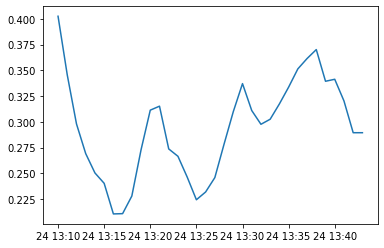

time
2020-04-24 13:10:00    0.536443
2020-04-24 13:11:00    0.530413
2020-04-24 13:12:00    0.541769
2020-04-24 13:13:00    0.557751
2020-04-24 13:14:00    0.575229
2020-04-24 13:15:00    0.592034
2020-04-24 13:16:00    0.606306
2020-04-24 13:17:00    0.622966
2020-04-24 13:18:00    0.647373
2020-04-24 13:19:00    0.676369
2020-04-24 13:20:00    0.701221
2020-04-24 13:21:00    0.722554
2020-04-24 13:22:00    0.744459
2020-04-24 13:23:00    0.763309
2020-04-24 13:24:00    0.779545
2020-04-24 13:25:00    0.797013
2020-04-24 13:26:00    0.816869
2020-04-24 13:27:00    0.834009
2020-04-24 13:28:00    0.772388
2020-04-24 13:29:00    0.719142
2020-04-24 13:30:00    0.673114
2020-04-24 13:31:00    0.594162
2020-04-24 13:32:00    0.560100
2020-04-24 13:33:00    0.550298
2020-04-24 13:34:00    0.541816
2020-04-24 13:35:00    0.543330
2020-04-24 13:36:00    0.544640
2020-04-24 13:37:00    0.545775
2020-04-24 13:38:00    0.554485
2020-04-24 13:39:00    0.578109
2020-04-24 13:40:00    0.602387
202

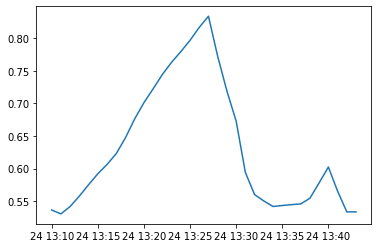

In [11]:
for symbol in symbols.keys():
    print(symbols[symbol].ADX)
    plt.plot(symbols[symbol].ADX)
    plt.show()

                             K          D           J
time                                                 
2020-04-24 12:43:00  39.065817  46.355272   24.486907
2020-04-24 12:44:00  31.684904  41.465150   12.124413
2020-04-24 12:45:00  44.713013  42.547771   49.043497
2020-04-24 12:46:00  62.400090  49.165211   88.869850
2020-04-24 12:47:00  59.007468  52.445963   72.130477
2020-04-24 12:48:00  42.883285  49.258404   30.133048
2020-04-24 12:49:00  37.107861  45.208223   20.907137
2020-04-24 12:50:00  28.408299  39.608248    6.008400
2020-04-24 12:51:00  26.448023  35.221506    8.901057
2020-04-24 12:52:00  19.158267  29.867093   -2.259385
2020-04-24 12:53:00  21.561731  27.098639   10.487915
2020-04-24 12:54:00  27.952254  27.383177   29.090407
2020-04-24 12:55:00  31.007178  28.591178   35.839179
2020-04-24 12:56:00  35.004056  30.728804   43.554561
2020-04-24 12:57:00  42.173572  34.543727   57.433264
2020-04-24 12:58:00  49.862970  39.650141   70.288628
2020-04-24 12:59:00  54.3338

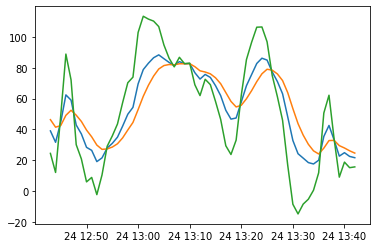

                             K          D           J
time                                                 
2020-04-24 12:44:00  33.333333  44.444444   11.111111
2020-04-24 12:45:00  22.222222  37.037037   -7.407407
2020-04-24 12:46:00  20.561941  31.545338   -1.404853
2020-04-24 12:47:00  18.609922  27.233533    1.362699
2020-04-24 12:48:00  19.269360  24.578808    8.650462
2020-04-24 12:49:00  34.414867  27.857495   47.529612
2020-04-24 12:50:00  31.766774  29.160588   36.979147
2020-04-24 12:51:00  40.785693  33.035623   56.285832
2020-04-24 12:52:00  52.680658  39.583968   78.874038
2020-04-24 12:53:00  58.649850  45.939262   84.071027
2020-04-24 12:54:00  57.490705  49.789743   72.892629
2020-04-24 12:55:00  56.717941  52.099142   65.955539
2020-04-24 12:56:00  39.002437  47.733574   21.540163
2020-04-24 12:57:00  33.779402  43.082183   15.173840
2020-04-24 12:58:00  24.371453  36.845273   -0.576186
2020-04-24 12:59:00  22.173562  31.954703    2.611279
2020-04-24 13:00:00  31.0786

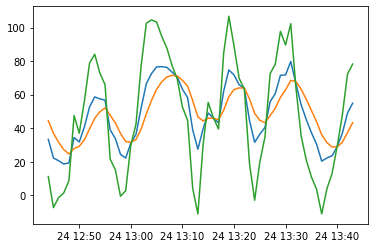

                             K          D           J
time                                                 
2020-04-24 12:44:00  36.111111  45.370370   17.592593
2020-04-24 12:45:00  28.421900  39.720880    5.823940
2020-04-24 12:46:00  30.542136  36.661299   18.303811
2020-04-24 12:47:00  29.057076  34.126558   18.918113
2020-04-24 12:48:00  20.653436  29.635517    2.689272
2020-04-24 12:49:00  26.589470  28.620168   22.528073
2020-04-24 12:50:00  22.854518  26.698285   15.166985
2020-04-24 12:51:00  17.617298  23.671289    5.509315
2020-04-24 12:52:00  14.125818  20.489465    1.398522
2020-04-24 12:53:00  15.477818  18.818916    8.795621
2020-04-24 12:54:00  19.577804  19.071879   20.589656
2020-04-24 12:55:00  19.192221  19.111993   19.352676
2020-04-24 12:56:00  15.651957  17.958647   11.038575
2020-04-24 12:57:00  14.244162  16.720485    9.291514
2020-04-24 12:58:00  14.000612  15.813861   10.374114
2020-04-24 12:59:00  12.111519  14.579747    7.175064
2020-04-24 13:00:00  37.8040

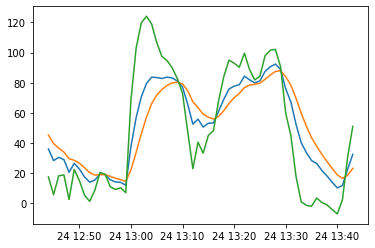

In [12]:
for symbol in symbols.keys():
    print(symbols[symbol].KDJ)
    plt.plot(symbols[symbol].KDJ)
    plt.show()

time
2020-04-24 12:43:00    0.000000
2020-04-24 12:44:00   -0.007179
2020-04-24 12:45:00    0.085742
2020-04-24 12:46:00    0.215082
2020-04-24 12:47:00    0.167029
2020-04-24 12:48:00    0.022971
2020-04-24 12:49:00   -0.072076
2020-04-24 12:50:00   -0.187440
2020-04-24 12:51:00   -0.557197
2020-04-24 12:52:00   -0.962823
2020-04-24 12:53:00   -1.190754
2020-04-24 12:54:00   -1.184560
2020-04-24 12:55:00   -1.204924
2020-04-24 12:56:00   -1.177277
2020-04-24 12:57:00   -1.128945
2020-04-24 12:58:00   -1.002876
2020-04-24 12:59:00   -0.927703
2020-04-24 13:00:00   -0.438831
2020-04-24 13:01:00    0.009565
2020-04-24 13:02:00    0.464559
2020-04-24 13:03:00    0.974608
2020-04-24 13:04:00    1.350501
2020-04-24 13:05:00    1.514596
2020-04-24 13:06:00    1.604918
2020-04-24 13:07:00    1.659760
2020-04-24 13:08:00    1.797454
2020-04-24 13:09:00    1.891530
2020-04-24 13:10:00    1.971439
2020-04-24 13:11:00    2.044021
2020-04-24 13:12:00    2.085674
2020-04-24 13:13:00    2.154014
202

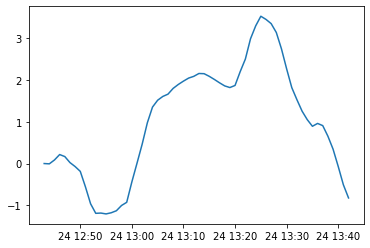

time
2020-04-24 12:44:00    0.000000e+00
2020-04-24 12:45:00   -1.570513e-07
2020-04-24 12:46:00   -2.931443e-07
2020-04-24 12:47:00   -5.283810e-07
2020-04-24 12:48:00   -5.654967e-07
2020-04-24 12:49:00    6.422994e-08
2020-04-24 12:50:00   -1.219485e-07
2020-04-24 12:51:00    2.783319e-07
2020-04-24 12:52:00    8.489654e-07
2020-04-24 12:53:00    1.138387e-06
2020-04-24 12:54:00    9.053586e-07
2020-04-24 12:55:00    7.221965e-07
2020-04-24 12:56:00   -2.140561e-07
2020-04-24 12:57:00   -6.802489e-07
2020-04-24 12:58:00   -1.675907e-06
2020-04-24 12:59:00   -2.592290e-06
2020-04-24 13:00:00   -2.392607e-06
2020-04-24 13:01:00   -2.273359e-06
2020-04-24 13:02:00   -1.191833e-06
2020-04-24 13:03:00    1.350926e-06
2020-04-24 13:04:00    2.836224e-06
2020-04-24 13:05:00    3.952364e-06
2020-04-24 13:06:00    4.431436e-06
2020-04-24 13:07:00    4.682470e-06
2020-04-24 13:08:00    4.683613e-06
2020-04-24 13:09:00    4.629615e-06
2020-04-24 13:10:00    4.462563e-06
2020-04-24 13:11:00    

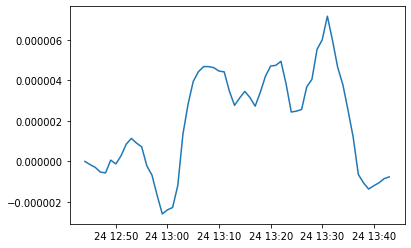

time
2020-04-24 12:44:00    0.000000
2020-04-24 12:45:00   -0.000673
2020-04-24 12:46:00    0.000693
2020-04-24 12:47:00    0.000575
2020-04-24 12:48:00   -0.002684
2020-04-24 12:49:00   -0.000745
2020-04-24 12:50:00   -0.002206
2020-04-24 12:51:00   -0.011236
2020-04-24 12:52:00   -0.017318
2020-04-24 12:53:00   -0.019835
2020-04-24 12:54:00   -0.020310
2020-04-24 12:55:00   -0.023129
2020-04-24 12:56:00   -0.028867
2020-04-24 12:57:00   -0.032207
2020-04-24 12:58:00   -0.035502
2020-04-24 12:59:00   -0.041195
2020-04-24 13:00:00   -0.026460
2020-04-24 13:01:00   -0.011698
2020-04-24 13:02:00    0.006845
2020-04-24 13:03:00    0.037351
2020-04-24 13:04:00    0.057826
2020-04-24 13:05:00    0.068294
2020-04-24 13:06:00    0.074924
2020-04-24 13:07:00    0.081251
2020-04-24 13:08:00    0.083825
2020-04-24 13:09:00    0.085549
2020-04-24 13:10:00    0.085893
2020-04-24 13:11:00    0.082299
2020-04-24 13:12:00    0.078539
2020-04-24 13:13:00    0.078323
2020-04-24 13:14:00    0.076515
202

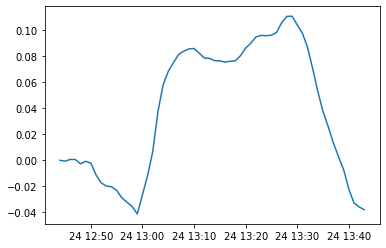

In [13]:
for symbol in symbols.keys():
    print(symbols[symbol].MACD)
    plt.plot(symbols[symbol].MACD)
    plt.show()

time
2020-04-24 12:43:00    0.000000
2020-04-24 12:44:00   -0.003989
2020-04-24 12:45:00    0.032786
2020-04-24 12:46:00    0.094540
2020-04-24 12:47:00    0.116104
2020-04-24 12:48:00    0.090860
2020-04-24 12:49:00    0.049625
2020-04-24 12:50:00   -0.007346
2020-04-24 12:51:00   -0.134365
2020-04-24 12:52:00   -0.319987
2020-04-24 12:53:00   -0.510506
2020-04-24 12:54:00   -0.655265
2020-04-24 12:55:00   -0.771591
2020-04-24 12:56:00   -0.856461
2020-04-24 12:57:00   -0.912945
2020-04-24 12:58:00   -0.931452
2020-04-24 12:59:00   -0.930685
2020-04-24 13:00:00   -0.830510
2020-04-24 13:01:00   -0.660038
2020-04-24 13:02:00   -0.432495
2020-04-24 13:03:00   -0.148455
2020-04-24 13:04:00    0.153565
2020-04-24 13:05:00    0.427387
2020-04-24 13:06:00    0.664011
2020-04-24 13:07:00    0.863916
2020-04-24 13:08:00    1.051189
2020-04-24 13:09:00    1.219665
2020-04-24 13:10:00    1.370311
2020-04-24 13:11:00    1.505262
2020-04-24 13:12:00    1.621488
2020-04-24 13:13:00    1.728099
202

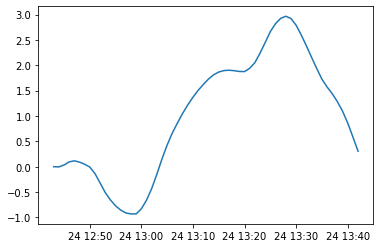

time
2020-04-24 12:44:00    0.000000e+00
2020-04-24 12:45:00   -8.725071e-08
2020-04-24 12:46:00   -1.716333e-07
2020-04-24 12:47:00   -2.924828e-07
2020-04-24 12:48:00   -3.736983e-07
2020-04-24 12:49:00   -2.549954e-07
2020-04-24 12:50:00   -2.213248e-07
2020-04-24 12:51:00   -1.012479e-07
2020-04-24 12:52:00    1.182561e-07
2020-04-24 12:53:00    3.468247e-07
2020-04-24 12:54:00    4.690287e-07
2020-04-24 12:55:00    5.233986e-07
2020-04-24 12:56:00    3.673275e-07
2020-04-24 12:57:00    1.481738e-07
2020-04-24 12:58:00   -2.299462e-07
2020-04-24 12:59:00   -7.160990e-07
2020-04-24 13:00:00   -1.059125e-06
2020-04-24 13:01:00   -1.306427e-06
2020-04-24 13:02:00   -1.283173e-06
2020-04-24 13:03:00   -7.502084e-07
2020-04-24 13:04:00   -2.624442e-08
2020-04-24 13:05:00    7.753922e-07
2020-04-24 13:06:00    1.510943e-06
2020-04-24 13:07:00    2.148258e-06
2020-04-24 13:08:00    2.657252e-06
2020-04-24 13:09:00    3.052920e-06
2020-04-24 13:10:00    3.335532e-06
2020-04-24 13:11:00    

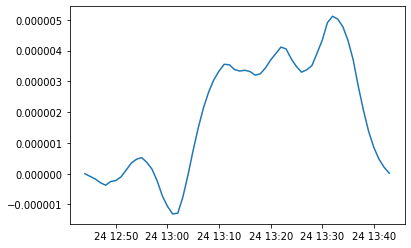

time
2020-04-24 12:44:00    0.000000
2020-04-24 12:45:00   -0.000374
2020-04-24 12:46:00    0.000063
2020-04-24 12:47:00    0.000237
2020-04-24 12:48:00   -0.000632
2020-04-24 12:49:00   -0.000663
2020-04-24 12:50:00   -0.001053
2020-04-24 12:51:00   -0.003501
2020-04-24 12:52:00   -0.006692
2020-04-24 12:53:00   -0.009637
2020-04-24 12:54:00   -0.011972
2020-04-24 12:55:00   -0.014368
2020-04-24 12:56:00   -0.017437
2020-04-24 12:57:00   -0.020527
2020-04-24 12:58:00   -0.023631
2020-04-24 12:59:00   -0.027245
2020-04-24 13:00:00   -0.027085
2020-04-24 13:01:00   -0.023951
2020-04-24 13:02:00   -0.017702
2020-04-24 13:03:00   -0.006563
2020-04-24 13:04:00    0.006435
2020-04-24 13:05:00    0.018899
2020-04-24 13:06:00    0.030170
2020-04-24 13:07:00    0.040435
2020-04-24 13:08:00    0.049146
2020-04-24 13:09:00    0.056449
2020-04-24 13:10:00    0.062352
2020-04-24 13:11:00    0.066349
2020-04-24 13:12:00    0.068791
2020-04-24 13:13:00    0.070700
2020-04-24 13:14:00    0.071864
202

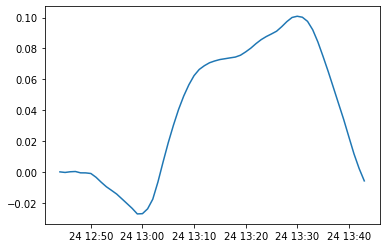

In [14]:
for symbol in symbols.keys():
    print(symbols[symbol].MACD_signal_line)
    plt.plot(symbols[symbol].MACD_signal_line)
    plt.show()

time
2020-04-24 12:43:00    0.000000
2020-04-24 12:44:00   -0.003191
2020-04-24 12:45:00    0.052956
2020-04-24 12:46:00    0.120542
2020-04-24 12:47:00    0.050926
2020-04-24 12:48:00   -0.067889
2020-04-24 12:49:00   -0.121701
2020-04-24 12:50:00   -0.180094
2020-04-24 12:51:00   -0.422832
2020-04-24 12:52:00   -0.642835
2020-04-24 12:53:00   -0.680248
2020-04-24 12:54:00   -0.529295
2020-04-24 12:55:00   -0.433332
2020-04-24 12:56:00   -0.320816
2020-04-24 12:57:00   -0.216000
2020-04-24 12:58:00   -0.071424
2020-04-24 12:59:00    0.002983
2020-04-24 13:00:00    0.391679
2020-04-24 13:01:00    0.669603
2020-04-24 13:02:00    0.897055
2020-04-24 13:03:00    1.123062
2020-04-24 13:04:00    1.196936
2020-04-24 13:05:00    1.087208
2020-04-24 13:06:00    0.940907
2020-04-24 13:07:00    0.795844
2020-04-24 13:08:00    0.746264
2020-04-24 13:09:00    0.671865
2020-04-24 13:10:00    0.601128
2020-04-24 13:11:00    0.538759
2020-04-24 13:12:00    0.464186
2020-04-24 13:13:00    0.425915
202

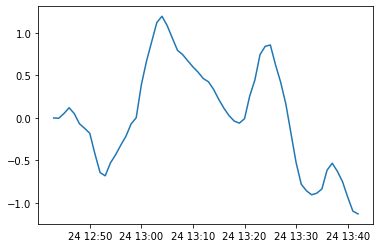

time
2020-04-24 12:44:00    0.000000e+00
2020-04-24 12:45:00   -6.980057e-08
2020-04-24 12:46:00   -1.215110e-07
2020-04-24 12:47:00   -2.358982e-07
2020-04-24 12:48:00   -1.917984e-07
2020-04-24 12:49:00    3.192253e-07
2020-04-24 12:50:00    9.937629e-08
2020-04-24 12:51:00    3.795797e-07
2020-04-24 12:52:00    7.307093e-07
2020-04-24 12:53:00    7.915626e-07
2020-04-24 12:54:00    4.363299e-07
2020-04-24 12:55:00    1.987979e-07
2020-04-24 12:56:00   -5.813836e-07
2020-04-24 12:57:00   -8.284226e-07
2020-04-24 12:58:00   -1.445960e-06
2020-04-24 12:59:00   -1.876191e-06
2020-04-24 13:00:00   -1.333482e-06
2020-04-24 13:01:00   -9.669325e-07
2020-04-24 13:02:00    9.134004e-08
2020-04-24 13:03:00    2.101134e-06
2020-04-24 13:04:00    2.862469e-06
2020-04-24 13:05:00    3.176971e-06
2020-04-24 13:06:00    2.920494e-06
2020-04-24 13:07:00    2.534212e-06
2020-04-24 13:08:00    2.026361e-06
2020-04-24 13:09:00    1.576695e-06
2020-04-24 13:10:00    1.127031e-06
2020-04-24 13:11:00    

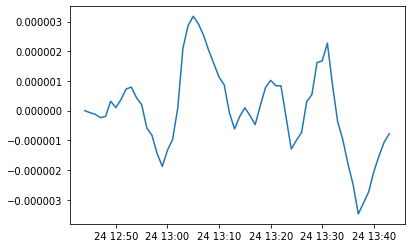

time
2020-04-24 12:44:00    0.000000
2020-04-24 12:45:00   -0.000299
2020-04-24 12:46:00    0.000630
2020-04-24 12:47:00    0.000338
2020-04-24 12:48:00   -0.002052
2020-04-24 12:49:00   -0.000082
2020-04-24 12:50:00   -0.001153
2020-04-24 12:51:00   -0.007735
2020-04-24 12:52:00   -0.010626
2020-04-24 12:53:00   -0.010198
2020-04-24 12:54:00   -0.008338
2020-04-24 12:55:00   -0.008761
2020-04-24 12:56:00   -0.011430
2020-04-24 12:57:00   -0.011680
2020-04-24 12:58:00   -0.011871
2020-04-24 12:59:00   -0.013949
2020-04-24 13:00:00    0.000625
2020-04-24 13:01:00    0.012253
2020-04-24 13:02:00    0.024547
2020-04-24 13:03:00    0.043914
2020-04-24 13:04:00    0.051391
2020-04-24 13:05:00    0.049396
2020-04-24 13:06:00    0.044753
2020-04-24 13:07:00    0.040816
2020-04-24 13:08:00    0.034679
2020-04-24 13:09:00    0.029101
2020-04-24 13:10:00    0.023541
2020-04-24 13:11:00    0.015950
2020-04-24 13:12:00    0.009748
2020-04-24 13:13:00    0.007623
2020-04-24 13:14:00    0.004651
202

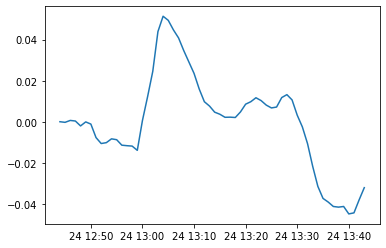

In [15]:
for symbol in symbols.keys():
    print(symbols[symbol].MACD_histogram)
    plt.plot(symbols[symbol].MACD_histogram)
    plt.show()

time
2020-04-24 13:21:00    6.253091
2020-04-24 13:22:00    6.526260
2020-04-24 13:23:00    6.780451
2020-04-24 13:24:00    7.011219
2020-04-24 13:25:00    7.199599
2020-04-24 13:26:00    7.292490
2020-04-24 13:27:00    7.298593
2020-04-24 13:28:00    7.221619
2020-04-24 13:29:00    7.038911
2020-04-24 13:30:00    6.744737
2020-04-24 13:31:00    6.397557
2020-04-24 13:32:00    6.046365
2020-04-24 13:33:00    5.695361
2020-04-24 13:34:00    5.327229
2020-04-24 13:35:00    4.957119
2020-04-24 13:36:00    4.603786
2020-04-24 13:37:00    4.265960
2020-04-24 13:38:00    3.923426
2020-04-24 13:39:00    3.587932
2020-04-24 13:40:00    3.188738
2020-04-24 13:41:00    2.752478
2020-04-24 13:42:00    2.300598
Name: BB_width, dtype: float64


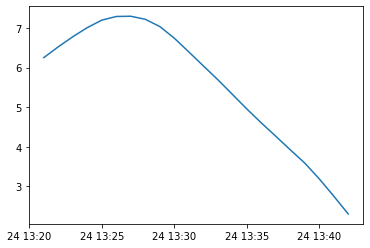

time
2020-04-24 13:22:00    0.000012
2020-04-24 13:23:00    0.000012
2020-04-24 13:24:00    0.000012
2020-04-24 13:25:00    0.000012
2020-04-24 13:26:00    0.000012
2020-04-24 13:27:00    0.000011
2020-04-24 13:28:00    0.000011
2020-04-24 13:29:00    0.000011
2020-04-24 13:30:00    0.000011
2020-04-24 13:31:00    0.000011
2020-04-24 13:32:00    0.000011
2020-04-24 13:33:00    0.000010
2020-04-24 13:34:00    0.000010
2020-04-24 13:35:00    0.000009
2020-04-24 13:36:00    0.000008
2020-04-24 13:37:00    0.000007
2020-04-24 13:38:00    0.000006
2020-04-24 13:39:00    0.000006
2020-04-24 13:40:00    0.000005
2020-04-24 13:41:00    0.000005
2020-04-24 13:42:00    0.000005
2020-04-24 13:43:00    0.000005
Name: BB_width, dtype: float64


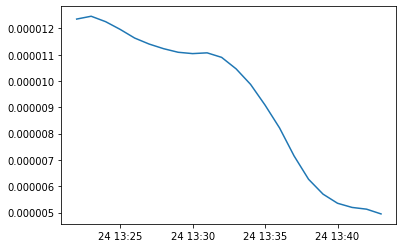

time
2020-04-24 13:22:00    0.259313
2020-04-24 13:23:00    0.265417
2020-04-24 13:24:00    0.268586
2020-04-24 13:25:00    0.269511
2020-04-24 13:26:00    0.268131
2020-04-24 13:27:00    0.265178
2020-04-24 13:28:00    0.261191
2020-04-24 13:29:00    0.255032
2020-04-24 13:30:00    0.246534
2020-04-24 13:31:00    0.237185
2020-04-24 13:32:00    0.226601
2020-04-24 13:33:00    0.214089
2020-04-24 13:34:00    0.199202
2020-04-24 13:35:00    0.182736
2020-04-24 13:36:00    0.165921
2020-04-24 13:37:00    0.149095
2020-04-24 13:38:00    0.133208
2020-04-24 13:39:00    0.120246
2020-04-24 13:40:00    0.107929
2020-04-24 13:41:00    0.096974
2020-04-24 13:42:00    0.087867
2020-04-24 13:43:00    0.078759
Name: BB_width, dtype: float64


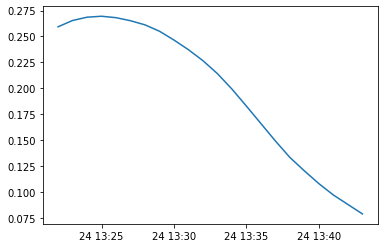

In [16]:
for symbol in symbols.keys():
    print(symbols[symbol].bollinger_bands)
    plt.plot(symbols[symbol].bollinger_bands)
    plt.show()

In [17]:
kraken_OHLC = get_kraken_OHLC()
kraken_OHLC

open         high          low        close  \
2020-04-24 00:37:00  7529.110000  7533.070000  7527.460000  7533.070000   
2020-04-24 00:39:00  7528.950000  7528.950000  7528.950000  7528.950000   
2020-04-24 00:40:00  7527.450000  7527.450000  7527.450000  7527.450000   
2020-04-24 00:41:00  7532.750000  7533.020000  7528.680000  7533.020000   
2020-04-24 00:42:00  7529.170000  7534.730000  7529.170000  7534.590000   
2020-04-24 00:43:00  7541.010000  7541.010000  7535.090000  7535.090000   
2020-04-24 00:44:00  7533.820000  7540.990000  7533.820000  7540.990000   
2020-04-24 00:45:00  7534.430000  7536.320000  7534.350000  7536.320000   
2020-04-24 00:46:00  7533.290000  7533.290000  7533.290000  7533.290000   
2020-04-24 00:47:00  7540.970000  7540.970000  7537.510000  7537.510000   
2020-04-24 00:48:00  7532.710000  7540.980000  7532.710000  7536.740000   
2020-04-24 00:49:00  7537.520000  7537.520000  7537.520000  7537.520000   
2020-04-24 00:50:00  7540.980000  7542.290000  7537.520000  7537.520000   
2020-04-24 00:52:00  7536.940000  7536.940000  7536.940000  7536.940000   
2020-04-24 00:53:00  7533.560000  7533.560000  7533.560000  7533.560000   
2020-04-24 00:54:00  7531.020000  7531.020000  7530.940000  7530.940000   
2020-04-24 00:55:00  7534.140000  7534.140000  7534.140000  7534.140000   
2020-04-24 00:56:00  7534.380000  7534.390000  7528.720000  7528.720000   
2020-04-24 00:57:00  7537.220000  7539.580000  7537.220000  7539.580000   
2020-04-24 00:58:00  7539.580000  7542.880000  7535.000000  7535.320000   
2020-04-24 00:59:00  7540.670000  7540.670000  7540.670000  7540.670000   
2020-04-24 01:00:00  7540.730000  7549.350000  7540.730000  7546.830000   
2020-04-24 01:01:00  7550.880000  7552.310000  7543.640000  7543.640000   
2020-04-24 01:02:00  7543.530000  7549.110000  7543.530000  7543.530000   
2020-04-24 01:03:00  7543.530000  7543.530000  7543.530000  7543.530000   
2020-04-24 01:04:00  7544.860000  7544.860000  7537.000000  7537.000000   
2020-04-24 01:05:00  7536.410000  7543.680000  7536.410000  7543.680000   
2020-04-24 01:06:00  7537.140000  7538.670000  7526.910000  7526.910000   
2020-04-24 01:07:00  7534.390000  7534.390000  7527.340000  7534.380000   
2020-04-24 01:08:00  7534.480000  7534.480000  7527.250000  7529.550000   
...                          ...          ...          ...          ...   
2020-04-24 17:11:00  7548.000000  7548.010000  7541.500000  7541.830000   
2020-04-24 17:12:00  7541.830000  7548.720000  7541.830000  7541.900000   
2020-04-24 17:13:00  7549.600000  7549.610000  7541.910000  7549.600000   
2020-04-24 17:14:00  7542.900000  7542.900000  7542.900000  7542.900000   
2020-04-24 17:15:00  7550.340000  7550.340000  7543.500000  7550.000000   
2020-04-24 17:16:00  7543.000000  7550.000000  7543.000000  7550.000000   
2020-04-24 17:17:00  7550.000000  7553.060000  7544.400000  7544.880000   
2020-04-24 17:18:00  7552.700000  7552.700000  7545.070000  7552.250000   
2020-04-24 17:19:00  7552.250000  7552.250000  7545.270000  7552.060000   
2020-04-24 17:21:00  7552.700000  7552.700000  7552.700000  7552.700000   
2020-04-24 17:22:00  7548.050000  7556.140000  7548.050000  7556.140000   
2020-04-24 17:23:00  7550.130000  7557.980000  7550.130000  7557.980000   
2020-04-24 17:24:00  7557.980000  7558.000000  7552.290000  7558.000000   
2020-04-24 17:25:00  7558.000000  7558.000000  7558.000000  7558.000000   
2020-04-24 17:26:00  7558.000000  7558.000000  7558.000000  7558.000000   
2020-04-24 17:27:00  7558.000000  7558.000000  7552.350000  7552.350000   
2020-04-24 17:28:00  7555.660000  7558.000000  7552.350000  7558.000000   
2020-04-24 17:29:00  7551.880000  7551.890000  7551.880000  7551.890000   
2020-04-24 17:30:00  7554.930000  7558.000000  7551.880000  7557.630000   
2020-04-24 17:31:00  7551.880000  7557.980000  7551.880000  7551.880000   
2020-04-24 17:32:00  7546.180000  7551.880000  7546.180000  7551.880000   
2020-04-24 17:34:00  7551.880000  7556.220000  7551.8

In [18]:
BTCUSD_price = get_BTCUSD_price()
BTCUSD_price_before = BTCUSD_price
BTCUSD_price_just_before = BTCUSD_price
BTCUSD_price

7551.75

In [19]:
for symbol in symbols.keys():
    symbols[symbol].dataset = symbols[symbol].dataset[['open', 'high', 'low', 'close', 'volume']]
    symbols[symbol].dataset = symbols[symbol].dataset.astype(float)

buy_USDT_balance:  0.04486191
buy_BTC_last_price:  7527.56
buy_BTC_balance:  5.959688132675129e-06
sell_BTC_balance:  0.01125278
sell_USDT_last_price:  7527.29
sell_USDT_balance:  84.7029383662
USDT_balance_combined:  84.7478002762
BTC_balance_combined:  0.011258739688132676


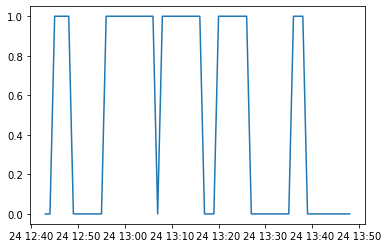

Just sold BTC.


Unhandled Error
Traceback (most recent call last):
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 103, in callWithLogger
    return callWithContext({"system": lp}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 86, in callWithContext
    return context.call({ILogContext: newCtx}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 122, in callWithContext
    return self.currentContext().callWithContext(ctx, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 85, in callWithContext
    return func(*args,**kw)
--- <exception caught here> ---
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/posixbase.py", line 614, in _doReadOrWrite
    why = selectable.doRead()
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/tcp.py", l

buy_USDT_balance:  84.63893316
buy_BTC_last_price:  7529.07
buy_BTC_balance:  0.011241618574405603
sell_BTC_balance:  2.78e-06
sell_USDT_last_price:  7528.97
sell_USDT_balance:  0.0209305366
USDT_balance_combined:  84.6598636966
BTC_balance_combined:  0.011244398574405604


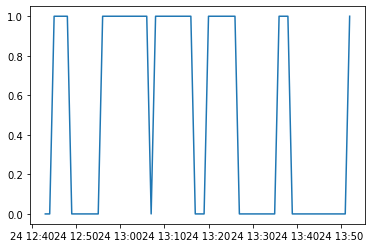

Just bought BTC.


In [ ]:
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                                   "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                                   "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                                   "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                                   "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                                 index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                                 columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-5000000:]
        else:
            dataset = dataset.append(last_data).iloc[-5000000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':
                if symbols[symbol].position == 'sell' and (symbols[symbol].bollinger_bands.iloc[-1] / float(symbols[symbol].dataset['close'].iloc[-1])) > 0.0005 and symbols[symbol].trend.iloc[-1] == 1 and symbols[symbol].KDJ['J'].iloc[-1] > symbols[symbol].KDJ['D'].iloc[-1] and symbols[symbol].ADX.iloc[-1] > 0.25:
                    symbols[symbol].calculate_balance()

                    coins_available = symbols[symbol].buy_BTC_balance * percentage_to_trade
                    quantity = math.floor(coins_available * 10**symbols[symbol].step_size) / float(10**symbols[symbol].step_size)
                    if symbols[symbol].tick_size < 0:
                        quantity = math.floor(coins_available * abs(symbols[symbol].tick_size)) / float(abs(symbols[symbol].tick_size))

                    client.create_order(symbol=symbol, 
                                        side=Client.SIDE_BUY, 
                                        type=Client.ORDER_TYPE_MARKET, 
                                        quantity=quantity, 
                                        recvWindow=2000)

                    print_balances_BTCUSDT(symbols[symbol].buy_USDT_balance, 
                                           symbols[symbol].buy_BTC_last_price, 
                                           symbols[symbol].buy_BTC_balance, 
                                           symbols[symbol].sell_BTC_balance, 
                                           symbols[symbol].sell_USDT_last_price, 
                                           symbols[symbol].sell_USDT_balance, 
                                           symbols[symbol].USDT_balance_combined, 
                                           symbols[symbol].BTC_balance_combined)

                    symbols[symbol].position = 'buy'
                    symbols[symbol].state = 'entry'
                    plt.plot(symbols[symbol].trend)
                    plt.show()
                    print('Just bought ' + symbols[symbol].base_asset + '.')

                elif symbols[symbol].position == 'buy' and (symbols[symbol].bollinger_bands.iloc[-1] / float(symbols[symbol].dataset['close'].iloc[-1])) > 0.0005 and symbols[symbol].trend.iloc[-1] == 0 and symbols[symbol].KDJ['J'].iloc[-1] < symbols[symbol].KDJ['D'].iloc[-1] and symbols[symbol].ADX.iloc[-1] > 0.25:
                    symbols[symbol].calculate_balance()
                    coins_available = symbols[symbol].sell_BTC_balance * percentage_to_trade
                    quantity = math.floor(coins_available * 10**symbols[symbol].step_size) / float(10**symbols[symbol].step_size)
                    if symbols[symbol].tick_size < 0:
                        quantity = math.floor(coins_available * abs(symbols[symbol].tick_size)) / float(abs(symbols[symbol].tick_size))

                    client.create_order(symbol=symbol, 
                                        side=Client.SIDE_SELL, 
                                        type=Client.ORDER_TYPE_MARKET, 
                                        quantity=quantity, 
                                        recvWindow=2000)

                    print_balances_BTCUSDT(symbols[symbol].buy_USDT_balance, 
                                           symbols[symbol].buy_BTC_last_price, 
                                           symbols[symbol].buy_BTC_balance, 
                                           symbols[symbol].sell_BTC_balance, 
                                           symbols[symbol].sell_USDT_last_price, 
                                           symbols[symbol].sell_USDT_balance, 
                                           symbols[symbol].USDT_balance_combined, 
                                           symbols[symbol].BTC_balance_combined)

                    symbols[symbol].position = 'sell'
                    symbols[symbol].state = 'entry'
                    plt.plot(symbols[symbol].trend)
                    plt.show()
                    print('Just sold ' + symbols[symbol].base_asset + '.')
            elif symbols[symbol].state == 'entry':
                if symbols[symbol].position == 'sell' and (symbols[symbol].bollinger_bands.iloc[-1] / float(symbols[symbol].dataset['close'].iloc[-1])) > 0.0005 and symbols[symbol].trend.iloc[-1] == 1 and symbols[symbol].KDJ['J'].iloc[-1] > symbols[symbol].KDJ['D'].iloc[-1] and symbols[symbol].ADX.iloc[-1] > 0.25:
                    symbols[symbol].calculate_balance()

                    coins_available = symbols[symbol].buy_BTC_balance * percentage_to_trade
                    quantity = math.floor(coins_available * 10**symbols[symbol].step_size) / float(10**symbols[symbol].step_size)
                    if symbols[symbol].tick_size < 0:
                        quantity = math.floor(coins_available * abs(symbols[symbol].tick_size)) / float(abs(symbols[symbol].tick_size))

                    client.create_order(symbol=symbol, 
                                        side=Client.SIDE_BUY, 
                                        type=Client.ORDER_TYPE_MARKET, 
                                        quantity=quantity, 
                                        recvWindow=2000)

                    print_balances_BTCUSDT(symbols[symbol].buy_USDT_balance, 
                                           symbols[symbol].buy_BTC_last_price, 
                                           symbols[symbol].buy_BTC_balance, 
                                           symbols[symbol].sell_BTC_balance, 
                                           symbols[symbol].sell_USDT_last_price, 
                                           symbols[symbol].sell_USDT_balance, 
                                           symbols[symbol].USDT_balance_combined, 
                                           symbols[symbol].BTC_balance_combined)

                    symbols[symbol].position = 'buy'
                    symbols[symbol].state = 'entry'
                    plt.plot(symbols[symbol].trend)
                    plt.show()
                    print('Just bought ' + symbols[symbol].base_asset + '.')

                elif symbols[symbol].position == 'buy' and (symbols[symbol].bollinger_bands.iloc[-1] / float(symbols[symbol].dataset['close'].iloc[-1])) > 0.0005 and symbols[symbol].trend.iloc[-1] == 0 and symbols[symbol].KDJ['J'].iloc[-1] < symbols[symbol].KDJ['D'].iloc[-1] and symbols[symbol].ADX.iloc[-1] > 0.25:
                    symbols[symbol].calculate_balance()
                    coins_available = symbols[symbol].sell_BTC_balance * percentage_to_trade
                    quantity = math.floor(coins_available * 10**symbols[symbol].step_size) / float(10**symbols[symbol].step_size)
                    if symbols[symbol].tick_size < 0:
                        quantity = math.floor(coins_available * abs(symbols[symbol].tick_size)) / float(abs(symbols[symbol].tick_size))

                    client.create_order(symbol=symbol, 
                                        side=Client.SIDE_SELL, 
                                        type=Client.ORDER_TYPE_MARKET, 
                                        quantity=quantity, 
                                        recvWindow=2000)

                    print_balances_BTCUSDT(symbols[symbol].buy_USDT_balance, 
                                           symbols[symbol].buy_BTC_last_price, 
                                           symbols[symbol].buy_BTC_balance, 
                                           symbols[symbol].sell_BTC_balance, 
                                           symbols[symbol].sell_USDT_last_price, 
                                           symbols[symbol].sell_USDT_balance, 
                                           symbols[symbol].USDT_balance_combined, 
                                           symbols[symbol].BTC_balance_combined)

                    symbols[symbol].position = 'sell'
                    symbols[symbol].state = 'entry'
                    plt.plot(symbols[symbol].trend)
                    plt.show()
                    print('Just sold ' + symbols[symbol].base_asset + '.')

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], process_message)
bm.start()

BTC = 'buy'
ETH = 'buy'
USDT = 'buy'

while True:
    sleep(10)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    if symbols['BTCUSDT'].trend.iloc[-1] == 0 and symbols['ETHBTC'].trend.iloc[-1] == 0 and symbols['ETHUSDT'].trend.iloc[-1] == 0:
        ETH = 'sell'
        USDT = 'buy'

    elif symbols['BTCUSDT'].trend.iloc[-1] == 0 and symbols['ETHBTC'].trend.iloc[-1] == 1 and symbols['ETHUSDT'].trend.iloc[-1] == 0:
        BTC = 'sell'
        USDT = 'buy'

    elif symbols['BTCUSDT'].trend.iloc[-1] == 0 and symbols['ETHBTC'].trend.iloc[-1] == 1 and symbols['ETHUSDT'].trend.iloc[-1] == 1:
        BTC = 'sell'
        ETH = 'buy'

    elif symbols['BTCUSDT'].trend.iloc[-1] == 1 and symbols['ETHBTC'].trend.iloc[-1] == 0 and symbols['ETHUSDT'].trend.iloc[-1] == 0:
        BTC = 'buy'
        ETH = 'sell'

    elif symbols['BTCUSDT'].trend.iloc[-1] == 1 and symbols['ETHBTC'].trend.iloc[-1] == 0 and symbols['ETHUSDT'].trend.iloc[-1] == 1:
        BTC = 'buy'
        USDT = 'sell'

    elif symbols['BTCUSDT'].trend.iloc[-1] == 1 and symbols['ETHBTC'].trend.iloc[-1] == 1 and symbols['ETHUSDT'].trend.iloc[-1] == 1:
        ETH = 'buy'
        USDT = 'sell'


    if traded_symbol == 'BTCUSDT' and ETH == 'buy' and BTC == 'sell' and USDT == 'sell':
        if symbols['BTCUSDT'].position == 'buy':
            symbols['ETHBTC'].position = 'sell'
            symbols['ETHBTC'].state = 'exit'
            traded_symbol = 'ETHBTC'

        elif symbols['BTCUSDT'].position == 'sell':
            symbols['ETHUSDT'].position = 'sell'
            symbols['ETHUSDT'].state = 'exit'
            traded_symbol = 'ETHUSDT'

    elif traded_symbol == 'ETHBTC' and USDT == 'buy' and BTC == 'sell' and ETH == 'sell':
        if symbols['ETHBTC'].position == 'buy':
            symbols['ETHUSDT'].position = 'buy'
            symbols['ETHUSDT'].state = 'exit'
            traded_symbol = 'ETHUSDT'

        elif symbols['ETHBTC'].position == 'sell':
            symbols['BTCUSDT'].position = 'buy'
            symbols['BTCUSDT'].state = 'exit'
            traded_symbol = 'BTCUSDT'

    elif traded_symbol == 'ETHUSDT' and BTC == 'buy' and ETH == 'sell' and USDT == 'sell':
        if symbols['ETHUSDT'].position == 'buy':
            symbols['ETHBTC'].position = 'buy'
            symbols['ETHBTC'].state = 'exit'
            traded_symbol = 'ETHBTC'

        elif symbols['ETHUSDT'].position == 'sell':
            symbols['BTCUSDT'].position = 'sell'
            symbols['BTCUSDT'].state = 'exit'
            traded_symbol = 'BTCUSDT'

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()